In this notebook I will experiment with various preprocessing techniques and test their effect on SVM's performance.



In [2]:
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import spacy
spacy.load('en_core_web_sm')

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import numpy as np

import re

import contractions
from textacy.preprocessing import normalize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olija\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
sentiment140Df = pd.read_csv("sentiment140.training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None, usecols=[0,5], names=["sentimentScore", "tweet"])
# print("dataframe shape: " + str(sentiment140Df.shape) )

#  Sentiment column (0 = negative, 4 = positive)
print(sentiment140Df.columns.values)
# replace 4 with 1 (0 = negative, 1 = positive)
sentiment140Df['sentimentScore'] = sentiment140Df['sentimentScore'].replace(4,1)
def labelTrainingSentiment(score):
    if score == 0:
        return 'negative'
    if score == 1:
        return 'positive'


sentiment140Df['label'] = sentiment140Df['sentimentScore'].apply(lambda x: labelTrainingSentiment(x))
sentiment140Df.head(5)


['sentimentScore' 'tweet']


,sentimentScore,tweet,label
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,0,is upset that he can't update his Facebook by ...,negative
2,0,@Kenichan I dived many times for the ball. Man...,negative
3,0,my whole body feels itchy and like its on fire,negative
4,0,"@nationwideclass no, it's not behaving at all....",negative


In [27]:
# This emoji's dicitonary was taken from:
# https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners?scriptVersionId=68181216

emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

htmlSymbols = {"&amp;": "and", "&quot;": '"', "&apos;": "'", "&cent;": "cent", "&pound;": "pound", "&yen;": "yen", "&euro;": "euro",
            "&copy;": "copyright", "&reg;": "registered trademark"}

# Abbreviation dictionary adapted from:
# https://www.socialmediatoday.com/social-networks/sarah-snow/2015-07-08/get-out-your-twittonary-twitter-abbreviations-you-must-know

abbreviationsDict = {'cc': 'carbon-copy', 'cx': 'correction', 'ct': 'cuttweet', 'dm': 'direct message', 'ht': 'heard through', 'mt': 'modified tweet', 
            'prt': 'please retweet', 'rt': 'retweet', 'sp': 'sponsored', 'em': 'email marketing', 'ezine': 'electronic magazine', 'fb': 'facebook', 
            'li': 'linkedin', 'seo': 'search engine optimization', 'sm': 'social media', 'smm': 'social media marketing', 'smo': 'social media optimization', 
            'sn': 'social network', 'sroi': 'social return on investment', 'ugc': 'user generated content', 'ux': 'user experience', 'yt': 'youtube', 
            'abt': 'about', 'afaik': 'as far as i know', 'ayfkmwts': 'are you fucking kidding me with this shit', 'b4': 'before', 'bfn': 'bye for now', 
            'bgd': 'background', 'bh': 'blockhead', 'br': 'best regards', 'btw': 'by the way', 'cd9': 'code 9', 'chk': 'check', 'cul8r': 'see you later', 
            'dam': 'donâ€™t annoy me', 'dd': 'dear daughter', 'df': 'dear fiance', 'ds': 'dear son', 'dyk': 'did you know', 'eml': 'email', 'ema': 'email address', 
            'f2f': 'face to face', 'ftf': 'face to face', 'ff': 'follow friday', 'ffs': "for fuck's sake", 'fml': 'fuck my life', 'fotd': 'find of the day', 
            'ftw': 'for the win', 'fubar': 'fucked up beyond all repair', 'fwiw': "for what it's worth", 'gmafb': 'give me a fucking break', 'gr8': 'great', 
            'gtfooh': 'get the fuck out of here', 'gts': 'guess the song', 'hagn': 'have a good night', 'hand': 'have a nice day', 'hotd': 'headline of the day', 
            'hth': 'hope that helps', 'ic': 'i see', 'icymi': 'in case you missed it', 'idk': "i don't know", 'iirc': 'if i remember correctly', 
            'imho': 'in my humble opinion', 'irl': 'in real life', 'iwsn': 'i want sex now', 'jk': 'joke', 'js': 'just saying', 'jsyk': 'just so you know', 
            'jv': 'joint venture', 'kk': 'okay', 'kyso': 'knock your socks off', 'lbs': 'laughing but serious', 'lhh': 'laugh hella hard', 'lmao': 'laughing my ass off', 
            'lmk': 'let me know', 'lo': 'little one', 'lol': 'laugh out loud', 'mm': 'music monday', 'mirl': 'meet in real life', 'mrjn': 'marijuana', 
            'msm': 'main stream media', 'mtf': 'more to follow', 'nbd': 'no big deal', 'nct': 'nobody cares though', 'nfi': 'no further information or not fucking interested', 
            'nfw': 'no fucking way', 'njoy': 'enjoy', 'nsfw': 'not safe for work', 'nts': 'note to self', 'oh': 'overheard', 'omfg': 'oh my fucking god', 
            'omg': 'oh my god', 'oomf': 'one of my friends', 'orly': 'oh really', 'plmk': 'please let me know', 'pnp': 'party and play', 'poidh': "pictures or it didn't happen", 
            'qotd': 'quote of the day', 're': 'in reply to', 'rlrt': 'real life retweet', 'rtfm': 'read the fucking manual', 'rtq': 'read the question', 'sfw': 'safe for work', 
            'smdh': 'shaking my damn head', 'smh': 'shaking my head', 'snafu': 'situation normal all fucked up', 'srs': 'serious', 'stfu': 'shut the fuck up', 
            'stfw': 'search the fucking web', 'tftf': 'thanks for the follow', 'tftt': 'thanks for this tweet', 'tj': 'tweetjack', 'tl': 'timeline', 'tldr': "too long didn't read", 
            'tmb': 'tweet me back', 'tt': 'trending topic', 'ty': 'thank you', 'tyia': 'thank you in advance', 'tyt': 'take your time', 'tyvm': 'thank you very much', 
            'w': 'with', 'wtv': 'whatever', 'ygtr': 'you got that right', 'ykwim': 'you know what i mean', 'ykyat': "you know you're addicted to", 
            'ymmv': 'your mileage may vary', 'yolo': 'you only live once', 'yoyo': "you're on your own", 'yw': "you're welcome", 'brb' : 'be right back', 'gtg' : 'got to go'}


stops = stopwords.words('english')

def appendStopsNoApostrophes(wordList):
    newList = wordList
    for word in wordList:
        if word.find("'") != -1:
            newList.append(word.replace("'", ""))
            newList.remove(word)
    return newList

stops = appendStopsNoApostrophes(stops)

STOPWORDS = set(stops)

Working on the assumption that URLs, user mentions, and HTML symbols add no meaning, remove or replace these and any extra whitespace from the raw tweet data.

In [22]:
def initialPreprocessTweet(tweet):
     # to lower case
    cleanTweet = tweet.lower()
    # remove user mentions
    cleanTweet = re.sub("(@[A-Za-z0-9_]+)","", cleanTweet)
    # remove urls
    cleanTweet = re.sub("https?://[A-Za-z0-9./]*","", cleanTweet)
    # replace common html symbols
    for key in htmlSymbols.keys():
        cleanTweet = cleanTweet.replace(key, htmlSymbols[key])
    #normalize all whitespace, remove leading and trailing whitespace
    cleanTweet = normalize.whitespace(cleanTweet)    
    return cleanTweet

def replaceEmojis(tweet):
    #replace emojis with text translation
    cleanTweet = tweet
    for key in emojis.keys():
         cleanTweet = cleanTweet.replace(key, emojis[key])
    return cleanTweet

#method to remove stopwords
def removeStops(tweet):
    return " ".join([word for word in tweet.split() if word not in STOPWORDS])

#method to lematize words
nlp = spacy.load("en_core_web_sm",  disable=['parser', 'ner'])
def lemmatize(tweet):
    # lemmatizing words
    doc = nlp(tweet)
    cleanTweet = " ".join([token.lemma_ for token in doc])
    return cleanTweet

#method to remove shortwords
def removeShortWords(tweet):
    return " ".join([word for word in tweet.split() if len(word) > 3])

# expand abbreviations / acronyms - translate common abbreviations to their translation
def translateAbbreviations(tweet):
    cleanTweetList = tweet.split()
    for key in abbreviationsDict.keys():
        cleanTweetList = [abbreviationsDict[key] if item == key else item for item in cleanTweetList]
    return " ".join(cleanTweetList)

# method to expand English language contractions, including negation
def expandContractions(tweet):
    return contractions.fix(tweet)

# method for repeated letter normalization = goooooooood --> good (no english word has more than two consecutive letters the same)
def normalizeRepeatedChars(tweet):
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    cleanTweet = tweet
    for c in alphabet:
        cleanTweet = normalize.repeating_chars(cleanTweet, chars= c, maxn=2)
    return cleanTweet

def removeNonAlphaChars(tweet):
    # remove non alpha characters
    cleanTweet = re.sub("[^a-zA-Z ]","", tweet)
    #normalize all whitespace
    return normalize.whitespace(cleanTweet)    



In [148]:
exampleTweet = "Hello to the WORLD. Today is a gr8 day. i am feeling so goooooood.    There are 12345 reasons to be happy!!!!! :) I can't wait to go surfing.  :(  What are y'all up to today? @world @everyone https://www.google.com :) brb gtg "
cleanedTweet = initialPreprocessTweet(exampleTweet)

print(exampleTweet)
print(cleanedTweet)
print(replaceEmojis(cleanedTweet))
print(removeStops(cleanedTweet))
print(lemmatize(cleanedTweet))
print(removeShortWords(cleanedTweet))
print(translateAbbreviations(cleanedTweet))
print(expandContractions(cleanedTweet))
print(normalizeRepeatedChars(cleanedTweet))
print(removeNonAlphaChars(cleanedTweet))



Hello to the WORLD. Today is a gr8 day. i am feeling so goooooood.    There are 12345 reasons to be happy!!!!! :) I can't wait to go surfing.  :(  What are y'all up to today? @world @everyone https://www.google.com :) brb gtg 
hello to the world. today is a gr8 day. i am feeling so goooooood. there are 12345 reasons to be happy!!!!! :) i can't wait to go surfing. :( what are y'all up to today? :) brb gtg
hello to the world. today is a gr8 day. i am feeling so goooooood. there are 12345 reasons to be happy!!!!! smile i can't wait to go surfing. sad what are y'all up to today? smile brb gtg
hello world. today gr8 day. feeling goooooood. 12345 reasons happy!!!!! :) can't wait go surfing. :( y'all today? :) brb gtg
hello to the world . today be a gr8 day . I be feel so goooooood . there be 12345 reason to be happy ! ! ! ! ! :) I can not wait to go surf . :( what be you all up to today ? :) brb gtg
hello world. today day. feeling goooooood. there 12345 reasons happy!!!!! can't wait surfing.

In [149]:
sentiment140Df['initialPreprocessTweet'] = sentiment140Df['tweet'].apply(lambda x:initialPreprocessTweet(x))
sentiment140Df.head()

,sentimentScore,tweet,label,initialPreprocessTweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,"- awww, that's a bummer. you shoulda got david..."
1,0,is upset that he can't update his Facebook by ...,negative,is upset that he can't update his facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...,negative,i dived many times for the ball. managed to sa...
3,0,my whole body feels itchy and like its on fire,negative,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",negative,"no, it's not behaving at all. i'm mad. why am ..."


In [151]:
sentiment140Df['initialPreprocessNoPunct'] = sentiment140Df['initialPreprocessTweet'].apply(lambda x:removeNonAlphaChars(x))
#Note that the emojis replaced collumn also has non-Alpha characters (numbers and punctuation) removed
sentiment140Df['emojisReplaced'] = sentiment140Df['initialPreprocessTweet'].apply(lambda x:removeNonAlphaChars(replaceEmojis(x)))

In [152]:
sentiment140Df['noStops'] = sentiment140Df['initialPreprocessNoPunct'].apply(lambda x: removeStops(x))
sentiment140Df['lemmatized'] = sentiment140Df['initialPreprocessNoPunct'].apply(lambda x: lemmatize(x))

In [153]:
sentiment140Df['noShortWords'] = sentiment140Df['initialPreprocessNoPunct'].apply(lambda x: removeShortWords(x))
sentiment140Df['translateAbbreviations'] = sentiment140Df['initialPreprocessNoPunct'].apply(lambda x: translateAbbreviations(x))

In [154]:
sentiment140Df['expandContractions'] = sentiment140Df['initialPreprocessNoPunct'].apply(lambda x: expandContractions(x))
sentiment140Df['repeatedCharsNormalized'] = sentiment140Df['initialPreprocessNoPunct'].apply(lambda x: normalizeRepeatedChars(x))
sentiment140Df.head()

,sentimentScore,tweet,label,initialPreprocessTweet,initialPreprocessNoPunct,emojisReplaced,noStops,lemmatized,noShortWords,translateAbbreviations,expandContractions,repeatedCharsNormalized
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,"- awww, that's a bummer. you shoulda got david...",awww thats a bummer you shoulda got david carr...,awww thats a bummer you shoulda got david carr...,awww thats bummer shoulda got david carr third...,awww that s a bummer you shoulda get david car...,awww thats bummer shoulda david carr third,awww thats a bummer you shoulda got david carr...,awww that is a bummer you shoulda got david ca...,aww thats a bummer you shoulda got david carr ...
1,0,is upset that he can't update his Facebook by ...,negative,is upset that he can't update his facebook by ...,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,upset cant update facebook texting might cry r...,be upset that he can not update his facebook b...,upset that cant update facebook texting might ...,is upset that he cant update his facebook by t...,is upset that he cannot update his facebook by...,is upset that he cant update his facebook by t...
2,0,@Kenichan I dived many times for the ball. Man...,negative,i dived many times for the ball. managed to sa...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,dived many times ball managed save rest go bounds,I dive many time for the ball manage to save t...,dived many times ball managed save rest bounds,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,whole body feels itchy like fire,my whole body feel itchy and like its on fire,whole body feels itchy like fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",negative,"no, it's not behaving at all. i'm mad. why am ...",no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,behaving im mad cant see,no its not behave at all I m mad why be I here...,behaving here because cant over there,no its not behaving at all im mad why am i her...,no its not behaving at all i am mad why am i h...,no its not behaving at all im mad why am i her...


In [155]:
sentiment140Df.to_csv("sentiment140PreprocessingExperiment.csv", index=False)

In [ ]:
preprocessedSentiment140Df = pd.read_csv("sentiment140PreprocessingExperiment.csv")

In [4]:
preprocessedSentiment140Df.head()

,sentimentScore,tweet,label,initialPreprocessTweet,initialPreprocessNoPunct,emojisReplaced,noStops,lemmatized,noShortWords,translateAbbreviations,expandContractions,repeatedCharsNormalized
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,"- awww, that's a bummer. you shoulda got david...",awww thats a bummer you shoulda got david carr...,awww thats a bummer you shoulda got david carr...,awww thats bummer shoulda got david carr third...,awww that s a bummer you shoulda get david car...,awww thats bummer shoulda david carr third,awww thats a bummer you shoulda got david carr...,awww that is a bummer you shoulda got david ca...,aww thats a bummer you shoulda got david carr ...
1,0,is upset that he can't update his Facebook by ...,negative,is upset that he can't update his facebook by ...,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,upset cant update facebook texting might cry r...,be upset that he can not update his facebook b...,upset that cant update facebook texting might ...,is upset that he cant update his facebook by t...,is upset that he cannot update his facebook by...,is upset that he cant update his facebook by t...
2,0,@Kenichan I dived many times for the ball. Man...,negative,i dived many times for the ball. managed to sa...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,dived many times ball managed save rest go bounds,I dive many time for the ball manage to save t...,dived many times ball managed save rest bounds,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,whole body feels itchy like fire,my whole body feel itchy and like its on fire,whole body feels itchy like fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",negative,"no, it's not behaving at all. i'm mad. why am ...",no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,behaving im mad cant see,no its not behave at all I m mad why be I here...,behaving here because cant over there,no its not behaving at all im mad why am i her...,no its not behaving at all i am mad why am i h...,no its not behaving at all im mad why am i her...


In [6]:
# source: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def evaluateModel(modelName, svcModel, xTest, yTest):
    y_pred = svcModel.predict(xTest)
    print(classification_report(yTest, y_pred))
    cf_matrix = confusion_matrix(yTest, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Negative','False Positive', 'False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '', xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title (modelName + " Confusion Matrix", fontdict = {'size':18}, pad = 20)

# source: https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def showROCCurve(modelName, svcModel, xTest, yTest):
    Y_pred1 = svcModel.predict(xTest)
    fpr, tpr, thresholds = roc_curve(yTest, Y_pred1)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkred', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(modelName + ' ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

def trainAndTestSVC(columnString, testSize, randomState, vectoriser, modelName):
    X_train,X_test,Y_train, Y_test = train_test_split(preprocessedSentiment140Df[columnString].apply(lambda x: np.str_(x)), 
    preprocessedSentiment140Df['sentimentScore'], test_size=testSize, random_state=randomState)  
    # ngram_range required is tuple e.g. (1,1) or (1,2)
    # ngram_range 1,1 means only unigrams are considered, 1,2 unigrams and bigrams
    # Transforming Xtrain and Xtest data using TF-IDF
    vectoriser = vectoriser
    vectoriser.fit_transform(X_train)
    print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))
    X_train = vectoriser.transform(X_train)
    X_test  = vectoriser.transform(X_test)
    print("X_train shape: ", X_train.shape)
    print("Y_train shape: ", Y_train.shape)
    print("X_test shape: ", X_test.shape)
    print("Y_test shape: ", Y_test.shape)
    # Training SVM (LinearSVC) model
    svcModel = LinearSVC()
    svcModel.fit(X_train, Y_train)
    # evaluating model
    evaluateModel(modelName, svcModel, X_test, Y_test)
    showROCCurve(modelName, svcModel, X_test, Y_test)


No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.81      0.82    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



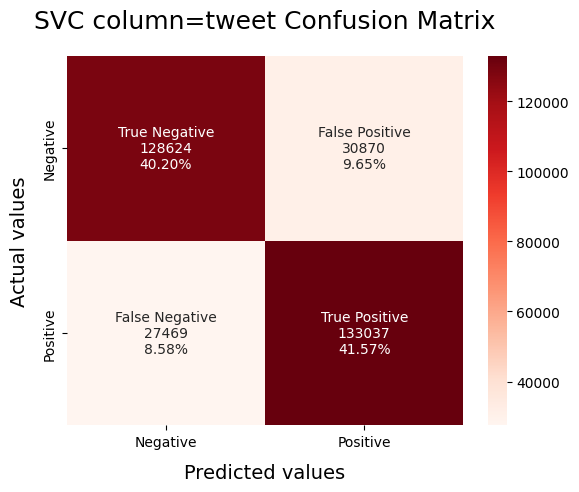

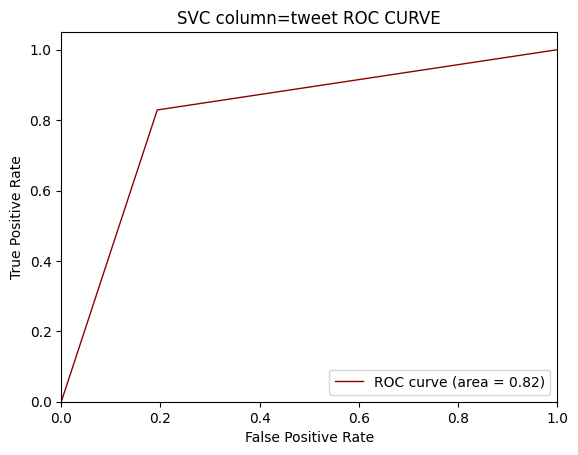

In [7]:
trainAndTestSVC(columnString="tweet", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=tweet")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.81      0.81    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



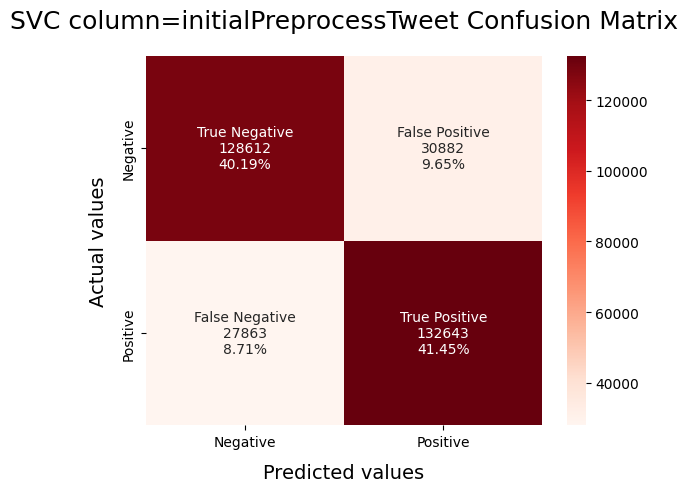

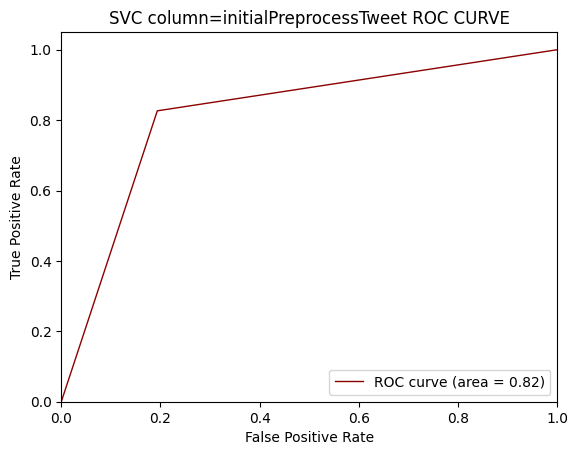

In [8]:
trainAndTestSVC(columnString="initialPreprocessTweet", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=initialPreprocessTweet")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



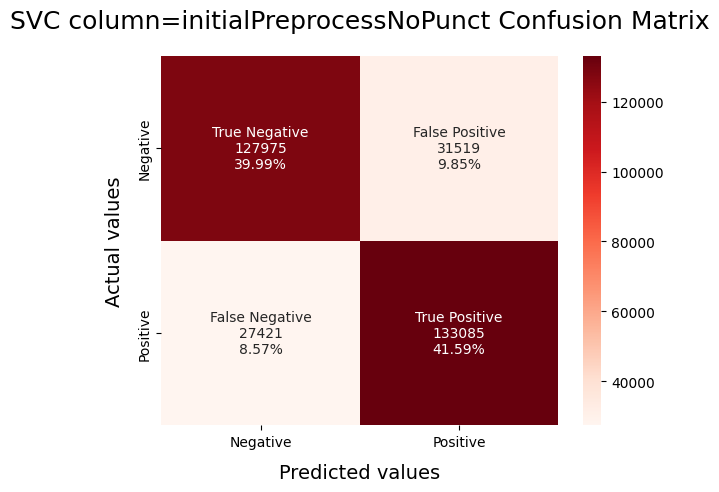

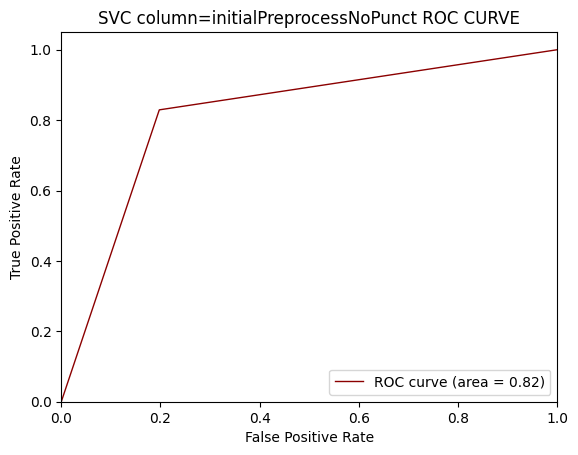

In [19]:
trainAndTestSVC(columnString="initialPreprocessNoPunct", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=initialPreprocessNoPunct")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



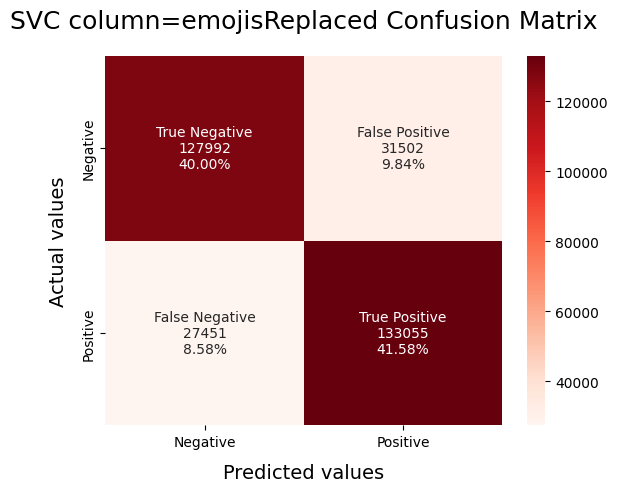

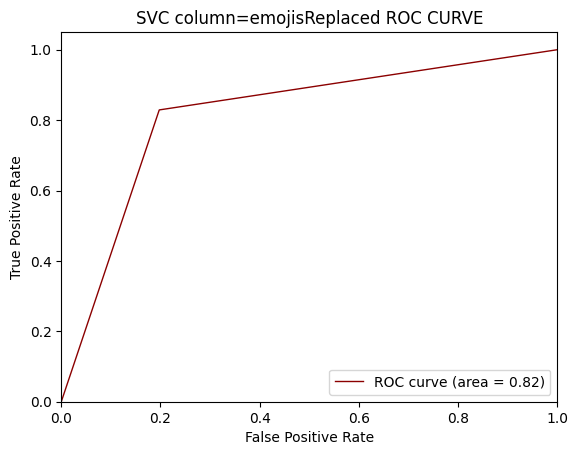

In [18]:
trainAndTestSVC(columnString="emojisReplaced", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=emojisReplaced")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159494
           1       0.77      0.81      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



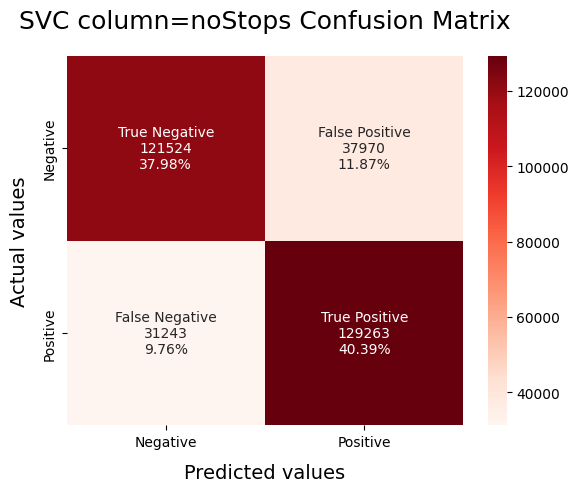

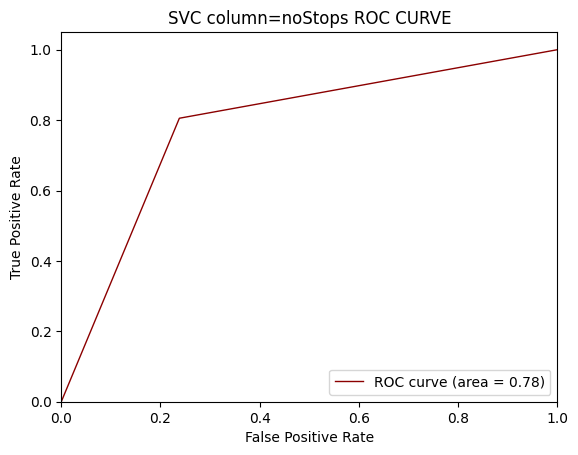

In [11]:
trainAndTestSVC(columnString="noStops", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=noStops")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           1       0.80      0.82      0.81    160506

    accuracy                           0.81    320000
   macro avg       0.81      0.81      0.81    320000
weighted avg       0.81      0.81      0.81    320000



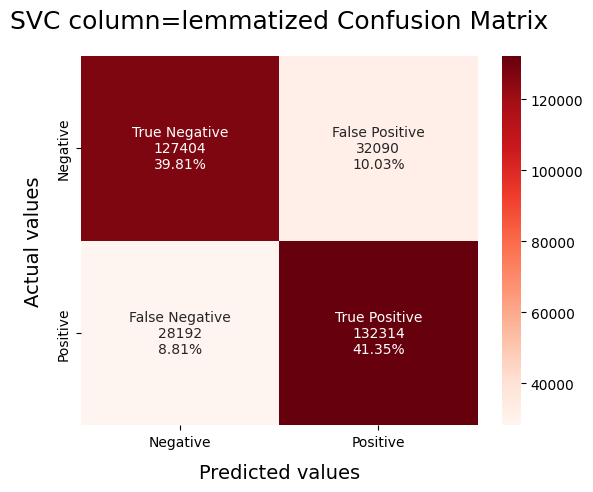

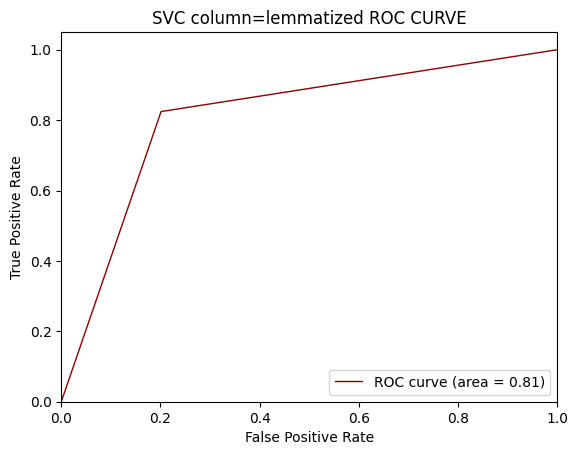

In [12]:
trainAndTestSVC(columnString="lemmatized", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=lemmatized")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.79      0.76      0.77    159494
           1       0.77      0.80      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



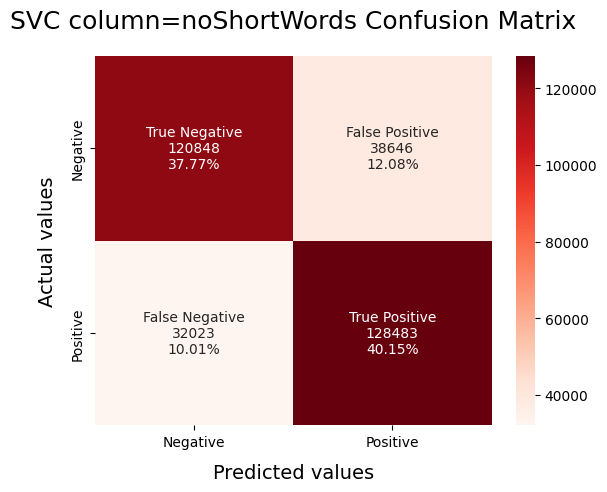

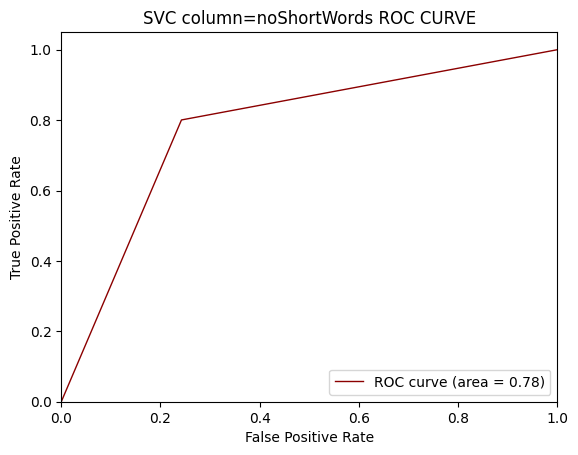

In [13]:
trainAndTestSVC(columnString="noShortWords", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=noShortWords")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



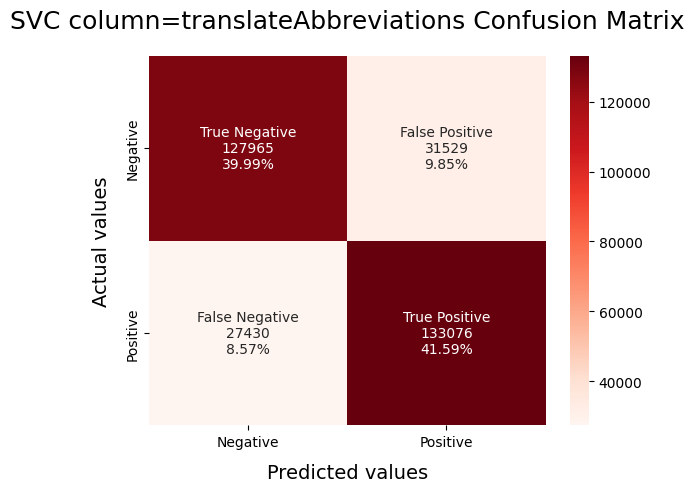

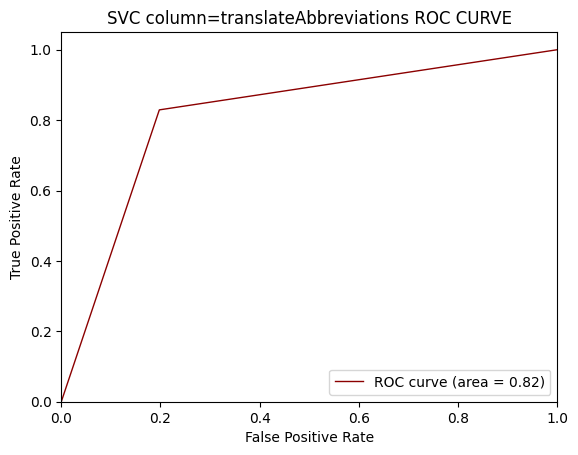

In [14]:
trainAndTestSVC(columnString="translateAbbreviations", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=translateAbbreviations")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



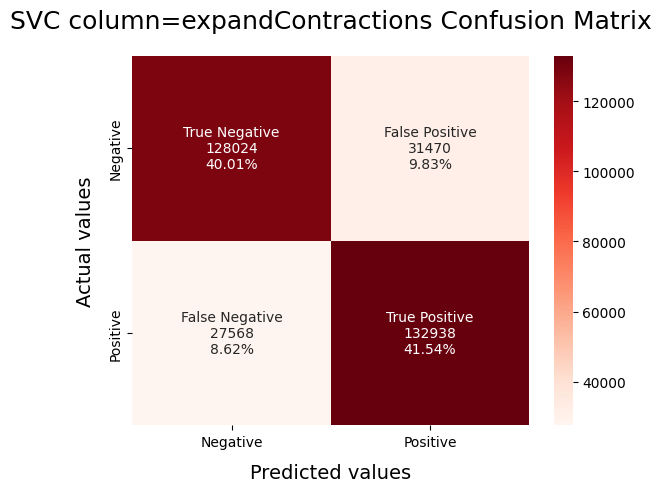

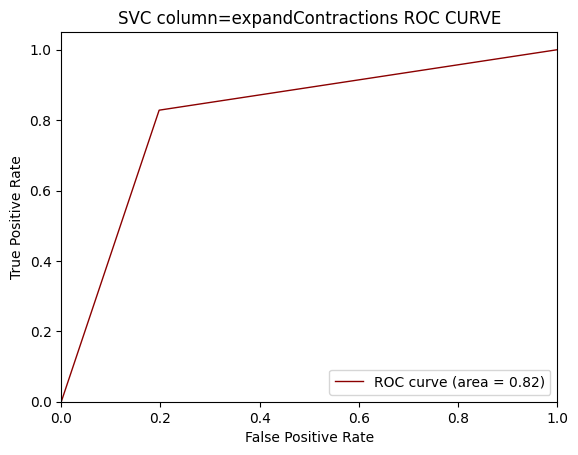

In [15]:
trainAndTestSVC(columnString="expandContractions", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=expandContractions")

No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



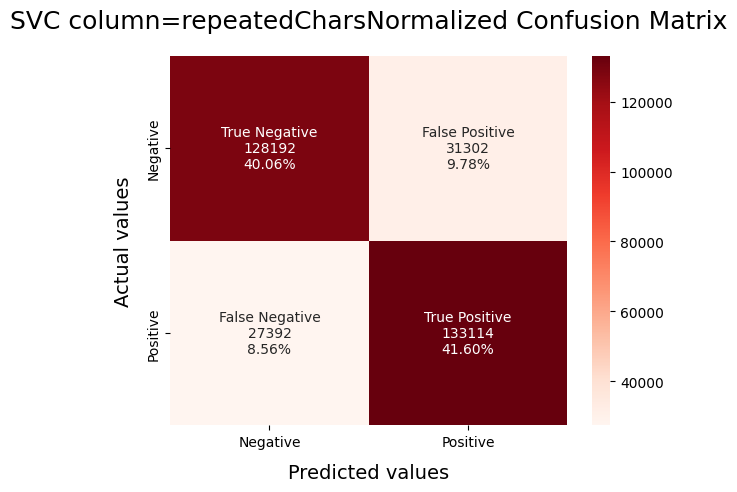

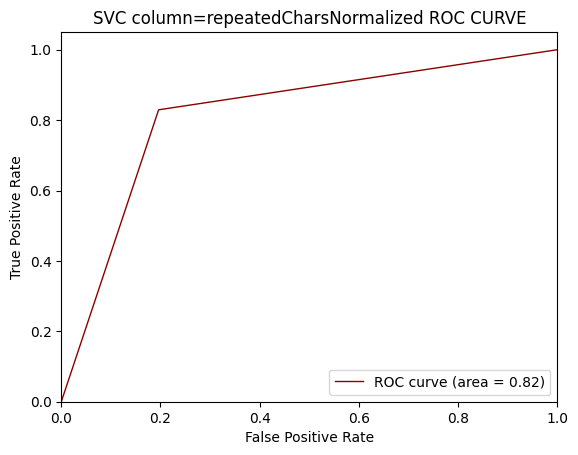

In [17]:
trainAndTestSVC(columnString="repeatedCharsNormalized", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=repeatedCharsNormalized")

Experimentation shows the following weighted averaged f1 scores of preprocessing techniques

tweet : 0.82
initialPreprocessTweet : 0.82
emojisReplaced : 0.82
noStops : 0.78
lemmatized : 0.81
noShortWords : 0.78
translateAbbreviations : 0.82
expandContractions : 0.82
repeatedCharsNormalized : 0.82

In [28]:
#This is the preprocessor informed by experimenting with various techniques. Only those techniques that improve or match performance have been included
def preprocessorA(tweet):
    preprocessedTweet = initialPreprocessTweet(tweet)
    preprocessedTweet = replaceEmojis(preprocessedTweet)
    preprocessedTweet = removeNonAlphaChars(preprocessedTweet)
    preprocessedTweet = normalizeRepeatedChars(preprocessedTweet)
    preprocessedTweet = expandContractions(preprocessedTweet)
    preprocessedTweet = translateAbbreviations(preprocessedTweet)
    return preprocessedTweet

preprocessedSentiment140Df['preprocessorA'] = preprocessedSentiment140Df['tweet'].apply(lambda x:preprocessorA(x))

preprocessedSentiment140Df.head()

preprocessedSentiment140Df.to_csv("sentiment140PreprocessingExperiment.csv", index=False)

In [32]:
preprocessedSentiment140Df.head()

,sentimentScore,tweet,label,initialPreprocessTweet,initialPreprocessNoPunct,emojisReplaced,noStops,lemmatized,noShortWords,translateAbbreviations,expandContractions,repeatedCharsNormalized,preprocessorA
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,"- awww, that's a bummer. you shoulda got david...",awww thats a bummer you shoulda got david carr...,awww thats a bummer you shoulda got david carr...,awww thats bummer shoulda got david carr third...,awww that s a bummer you shoulda get david car...,awww thats bummer shoulda david carr third,awww thats a bummer you shoulda got david carr...,awww that is a bummer you shoulda got david ca...,aww thats a bummer you shoulda got david carr ...,aww that is a bummer you shoulda got david car...
1,0,is upset that he can't update his Facebook by ...,negative,is upset that he can't update his facebook by ...,is upset that he cant update his facebook by t...,is upset that he cant update his facebook by t...,upset cant update facebook texting might cry r...,be upset that he can not update his facebook b...,upset that cant update facebook texting might ...,is upset that he cant update his facebook by t...,is upset that he cannot update his facebook by...,is upset that he cant update his facebook by t...,is upset that he cannot update his facebook by...
2,0,@Kenichan I dived many times for the ball. Man...,negative,i dived many times for the ball. managed to sa...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,dived many times ball managed save rest go bounds,I dive many time for the ball manage to save t...,dived many times ball managed save rest bounds,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,whole body feels itchy like fire,my whole body feel itchy and like its on fire,whole body feels itchy like fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",negative,"no, it's not behaving at all. i'm mad. why am ...",no its not behaving at all im mad why am i her...,no its not behaving at all im mad why am i her...,behaving im mad cant see,no its not behave at all I m mad why be I here...,behaving here because cant over there,no its not behaving at all im mad why am i her...,no its not behaving at all i am mad why am i h...,no its not behaving at all im mad why am i her...,no its not behaving at all i am mad why am i h...


No. of feature_words:  100000
X_train shape:  (1280000, 100000)
Y_train shape:  (1280000,)
X_test shape:  (320000, 100000)
Y_test shape:  (320000,)
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    159494
           1       0.81      0.83      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



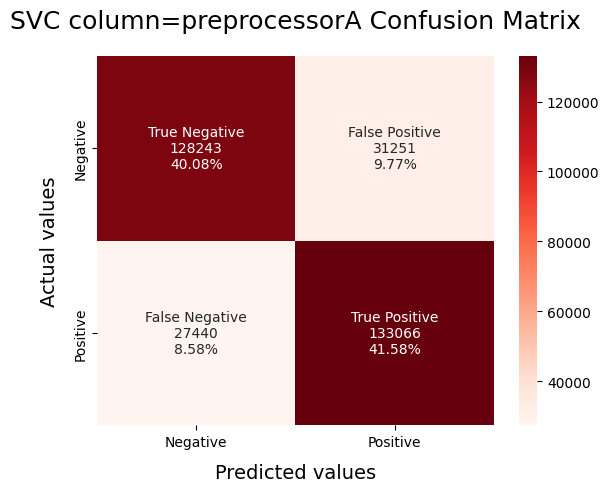

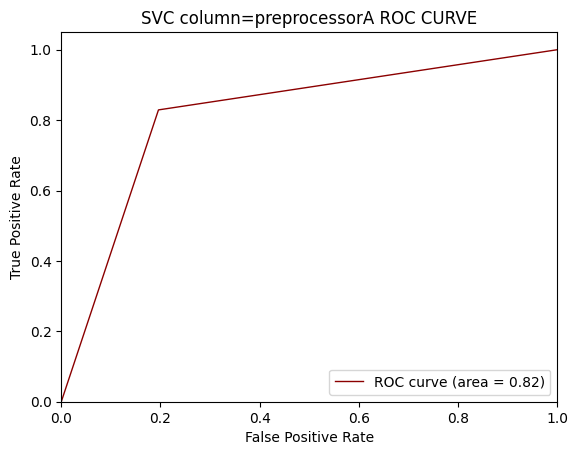

In [33]:
trainAndTestSVC(columnString="preprocessorA", testSize=0.2, randomState=42, vectoriser=TfidfVectorizer(ngram_range=(1,2), max_features=100000), modelName="SVC column=preprocessorA")

Experimenting with C 
Testing best C param looping through 0.05 - 1.0 in steps of 0.05. Data used is preprocessorA.

In [44]:
def svmTestC(cParam):
    X_train,X_test,Y_train, Y_test = train_test_split(preprocessedSentiment140Df["preprocessorA"].apply(lambda x: np.str_(x)), 
    preprocessedSentiment140Df['sentimentScore'], test_size=0.2, random_state=42)  
    tempVectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
    tempVectoriser.fit_transform(X_train)
    X_train = tempVectoriser.transform(X_train)
    X_test  = tempVectoriser.transform(X_test)
    tempSvcModel = LinearSVC(C=cParam)
    tempSvcModel.fit(X_train, Y_train)
    y_pred = tempSvcModel.predict(X_test)
    return classification_report(Y_test, y_pred, output_dict=True)


# testing best C parameter. using params = (lowerbound = 1, upperbound = 20, divisor = 20) will test c from 0.05 to 1.0
def getBestCParam(lowerbound, upperBound, divisor):
    bestC = 0
    cParambestF1 = 0
    for x in range(lowerbound, upperBound):
        c = x/divisor
        classifcationReportDict = svmTestC(c)
        if classifcationReportDict['weighted avg']['f1-score'] > cParambestF1:
            cParambestF1 = classifcationReportDict['weighted avg']['f1-score']
            bestC = c
    print("The optimum C parameter based upon f1-score is " + str(bestC))
    print(svmTestC(bestC))

getBestCParam(1, 20, 20)

The optimum C parameter based upon f1-score is 0.1
{'0': {'precision': 0.8300823106180054, 'recall': 0.8087075375876208, 'f1-score': 0.8192555282789371, 'support': 159494}, '1': {'precision': 0.814656193617758, 'recall': 0.8355014765803147, 'f1-score': 0.8249471731888939, 'support': 160506}, 'accuracy': 0.822146875, 'macro avg': {'precision': 0.8223692521178817, 'recall': 0.8221045070839678, 'f1-score': 0.8221013507339154, 'support': 320000}, 'weighted avg': {'precision': 0.8223448595703751, 'recall': 0.822146875, 'f1-score': 0.8221103506474293, 'support': 320000}}


Testing testSize

In [54]:
def svmTestTestSize(testSize):
    X_train,X_test,Y_train, Y_test = train_test_split(preprocessedSentiment140Df["preprocessorA"].apply(lambda x: np.str_(x)), 
    preprocessedSentiment140Df['sentimentScore'], test_size=testSize, random_state=42)  
    tempVectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
    tempVectoriser.fit_transform(X_train)
    X_train = tempVectoriser.transform(X_train)
    X_test  = tempVectoriser.transform(X_test)
    tempSvcModel = LinearSVC(C=0.1)
    tempSvcModel.fit(X_train, Y_train)
    y_pred = tempSvcModel.predict(X_test)
    return classification_report(Y_test, y_pred, output_dict=True)


# testing best testSize. using params = (lowerbound = 1, upperbound = 20, divisor = 20) will test c from 0.05 to 1.0
def getBestTestSize(lowerbound, upperBound, divisor):
    bestTestSize = 0
    testSizeBestF1 = 0
    for x in range(lowerbound, upperBound):
        testSize = x/divisor
        classifcationReportDict = svmTestTestSize(testSize)
        print("testSize = " + str(testSize) + " : f1 = " + str(classifcationReportDict['weighted avg']['f1-score']))
        if classifcationReportDict['weighted avg']['f1-score'] > testSizeBestF1:
            testSizeBestF1 = classifcationReportDict['weighted avg']['f1-score']
            bestTestSize = testSize
    print("The optimum test_size parameter based upon f1-score is " + str(bestTestSize))
    print(svmTestC(bestTestSize))

getBestTestSize(1, 8, 20)

testSize = 0.05 : f1 = 0.8225174738756846
testSize = 0.1 : f1 = 0.822423054781244
testSize = 0.15 : f1 = 0.8214546304055635
testSize = 0.2 : f1 = 0.8221103506474293
testSize = 0.25 : f1 = 0.8216214086368447
testSize = 0.3 : f1 = 0.8211564471389877
testSize = 0.35 : f1 = 0.8209823184841158
The optimum test_size parameter based upon f1-score is 0.05
{'0': {'precision': 0.8288791075652022, 'recall': 0.8064127804180722, 'f1-score': 0.8174916180700109, 'support': 159494}, '1': {'precision': 0.8126785941794223, 'recall': 0.8345669320773055, 'f1-score': 0.8234773387431417, 'support': 160506}, 'accuracy': 0.820534375, 'macro avg': {'precision': 0.8207788508723123, 'recall': 0.8204898562476888, 'f1-score': 0.8204844784065763, 'support': 320000}, 'weighted avg': {'precision': 0.8207532338105211, 'recall': 0.820534375, 'f1-score': 0.8204939433273907, 'support': 320000}}


In [48]:
print("Testing test size: 0.2")
print(svmTestTestSize(0.2))

Testing test size: 0.2
{'0': {'precision': 0.8300823106180054, 'recall': 0.8087075375876208, 'f1-score': 0.8192555282789371, 'support': 159494}, '1': {'precision': 0.814656193617758, 'recall': 0.8355014765803147, 'f1-score': 0.8249471731888939, 'support': 160506}, 'accuracy': 0.822146875, 'macro avg': {'precision': 0.8223692521178817, 'recall': 0.8221045070839678, 'f1-score': 0.8221013507339154, 'support': 320000}, 'weighted avg': {'precision': 0.8223448595703751, 'recall': 0.822146875, 'f1-score': 0.8221103506474293, 'support': 320000}}


testing TFIDF max_features

In [55]:
def svmTestMaxFeatures(maxFeatures):
    X_train,X_test,Y_train, Y_test = train_test_split(preprocessedSentiment140Df["preprocessorA"].apply(lambda x: np.str_(x)), 
    preprocessedSentiment140Df['sentimentScore'], test_size=0.2, random_state=42)  
    tempVectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=maxFeatures)
    tempVectoriser.fit_transform(X_train)
    X_train = tempVectoriser.transform(X_train)
    X_test  = tempVectoriser.transform(X_test)    
    tempSvcModel = LinearSVC(C=0.1)
    tempSvcModel.fit(X_train, Y_train)
    y_pred = tempSvcModel.predict(X_test)
    return classification_report(Y_test, y_pred, output_dict=True)


# testing best testSize. using params = (lowerbound = 1, upperbound = 20, divisor = 20) will test c from 0.05 to 1.0
def getBestMaxFeat():
    bestMaxFeatures = 0
    maxFeaturesBestF1 = 0
    maxFeatList = [250, 500, 1000, 2500, 5000, 10000, 25000, 50000, 100000, 250000, 500000]
    for x in maxFeatList:
        maxFeatures = x
        classifcationReportDict = svmTestMaxFeatures(maxFeatures)
        print("TFIDF maxFeatures = " + str(maxFeatures) + ": f1 = " + str(classifcationReportDict['weighted avg']['f1-score']))
        if classifcationReportDict['weighted avg']['f1-score'] > maxFeaturesBestF1:
            maxFeaturesBestF1 = classifcationReportDict['weighted avg']['f1-score']
            bestMaxFeatures = maxFeatures
    print("The optimum TF-IDF max_features parameter based upon f1-score is " + str(bestMaxFeatures))
    print(svmTestC(bestMaxFeatures))

getBestMaxFeat()

TFIDF maxFeatures = 250: f1 = 0.7174234381577108
TFIDF maxFeatures = 500: f1 = 0.7425604150391142
TFIDF maxFeatures = 1000: f1 = 0.761674584986504
TFIDF maxFeatures = 2500: f1 = 0.7843474049127017
TFIDF maxFeatures = 5000: f1 = 0.7972395654187936
TFIDF maxFeatures = 10000: f1 = 0.8064124536226531
TFIDF maxFeatures = 25000: f1 = 0.8150821634319857
TFIDF maxFeatures = 50000: f1 = 0.8194396388119725
TFIDF maxFeatures = 100000: f1 = 0.8221103506474293
TFIDF maxFeatures = 250000: f1 = 0.8234823725536841
TFIDF maxFeatures = 500000: f1 = 0.8237230965987852
The optimum TF-IDF max_features parameter based upon f1-score is 500000


c:\Users\olija\Documents\GitHub\CSCM20_Project\env\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'0': {'precision': 0.7565723363158813, 'recall': 0.788330595508295, 'f1-score': 0.7721250418351586, 'support': 159494}, '1': {'precision': 0.7805098464999253, 'recall': 0.7479533475384098, 'f1-score': 0.7638848678245211, 'support': 160506}, 'accuracy': 0.768078125, 'macro avg': {'precision': 0.7685410914079033, 'recall': 0.7681419715233524, 'f1-score': 0.7680049548298399, 'support': 320000}, 'weighted avg': {'precision': 0.7685789425958818, 'recall': 0.768078125, 'f1-score': 0.7679919250546855, 'support': 320000}}


              precision    recall  f1-score   support

           0       0.83      0.81      0.82    159494
           1       0.81      0.84      0.82    160506

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



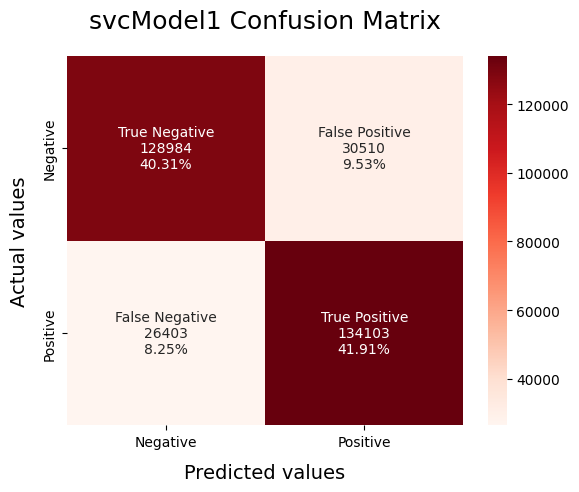

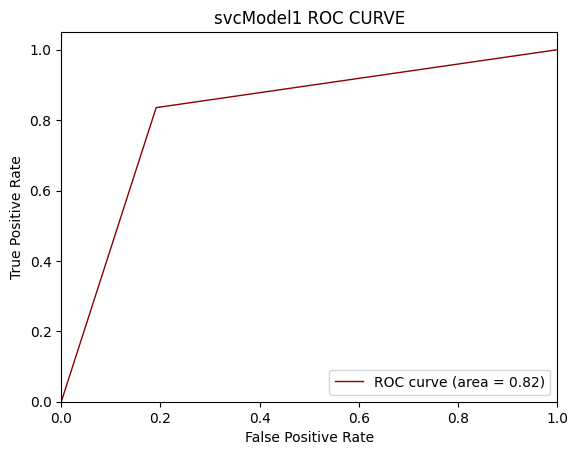

In [45]:
X_train,X_test,Y_train, Y_test = train_test_split(preprocessedSentiment140Df["preprocessorA"].apply(lambda x: np.str_(x)), 
preprocessedSentiment140Df['sentimentScore'], test_size=0.2, random_state=42)  
vectoriserA = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
vectoriserA.fit_transform(X_train)
X_train = vectoriserA.transform(X_train)
X_test  = vectoriserA.transform(X_test)
svcModel1 = LinearSVC(C=0.1)
svcModel1.fit(X_train, Y_train)
evaluateModel("svcModel1", svcModel1, X_test, Y_test)
showROCCurve("svcModel1", svcModel1, X_test, Y_test)